In [185]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import itertools
import tqdm
import random

%matplotlib inline

In [186]:
companies_df = pd.read_csv(
  "../data/cleansed_layer/companies_usa_size_over_10.csv", usecols=["name"]
)

companies = companies_df.name.to_list()

In [187]:
# random.seed(10110609)
# random.shuffle(companies)
# companies = random.sample(companies, 100000)
# companies[:5]

In [138]:
len(companies)

91073

In [139]:
companies[:5]

['equinoxys', 'biassync', 'taggpay', 'touchpointe', 'rxfit']

In [140]:
max([len(c) for c in companies])

16

In [141]:
min([len(c) for c in companies])

3

In [142]:
sum([len(c) for c in companies]) / len(companies)

8.164823822647767

In [143]:
alphabet = sorted(set("".join(companies)))
alphabet.insert(0, '.')
len_alphabet = len(alphabet)
len_alphabet

27

In [144]:
combinations = list(itertools.product(alphabet, repeat=2))
combinations = [''.join(comb) for comb in combinations]

In [145]:
len(combinations)

729

In [146]:
strtoint = {j: i for i, j in enumerate(alphabet)}
inttostr = {i: j for i, j in enumerate(alphabet)}

In [147]:
strtoint_bi = {j: i for i, j in enumerate(combinations)}
inttostr_bi = {i: j for i, j in enumerate(combinations)}

In [148]:
E = torch.zeros((len(alphabet) * len(alphabet), len(alphabet)), dtype=torch.int32)

In [149]:
E.shape

torch.Size([729, 27])

In [150]:
# word = "tesla"
for word in tqdm.tqdm(companies):  
  word = ['.', '.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
    int1, int2, int3 = strtoint[ch1], strtoint[ch2], strtoint[ch3]
    int12 = strtoint_bi[ch1+ch2]
    E[int12, int3] += 1
#     print(ch1, ch2, ch3)
#     print(int1, int2, int3)

100%|██████████████████████████████████████████████████| 91073/91073 [00:09<00:00, 9933.52it/s]


In [151]:
E

tensor([[   0, 7273, 4742,  ...,  490,  534,  916],
        [   0,  112,  180,  ...,   89,   36,   71],
        [   0,  636,   24,  ...,    1,   54,    5],
        ...,
        [   4,    0,    0,  ...,    0,    0,    0],
        [  42,    2,    6,  ...,    0,    2,    1],
        [  64,   34,    9,  ...,    0,   16,    2]], dtype=torch.int32)

In [152]:
E.shape

torch.Size([729, 27])

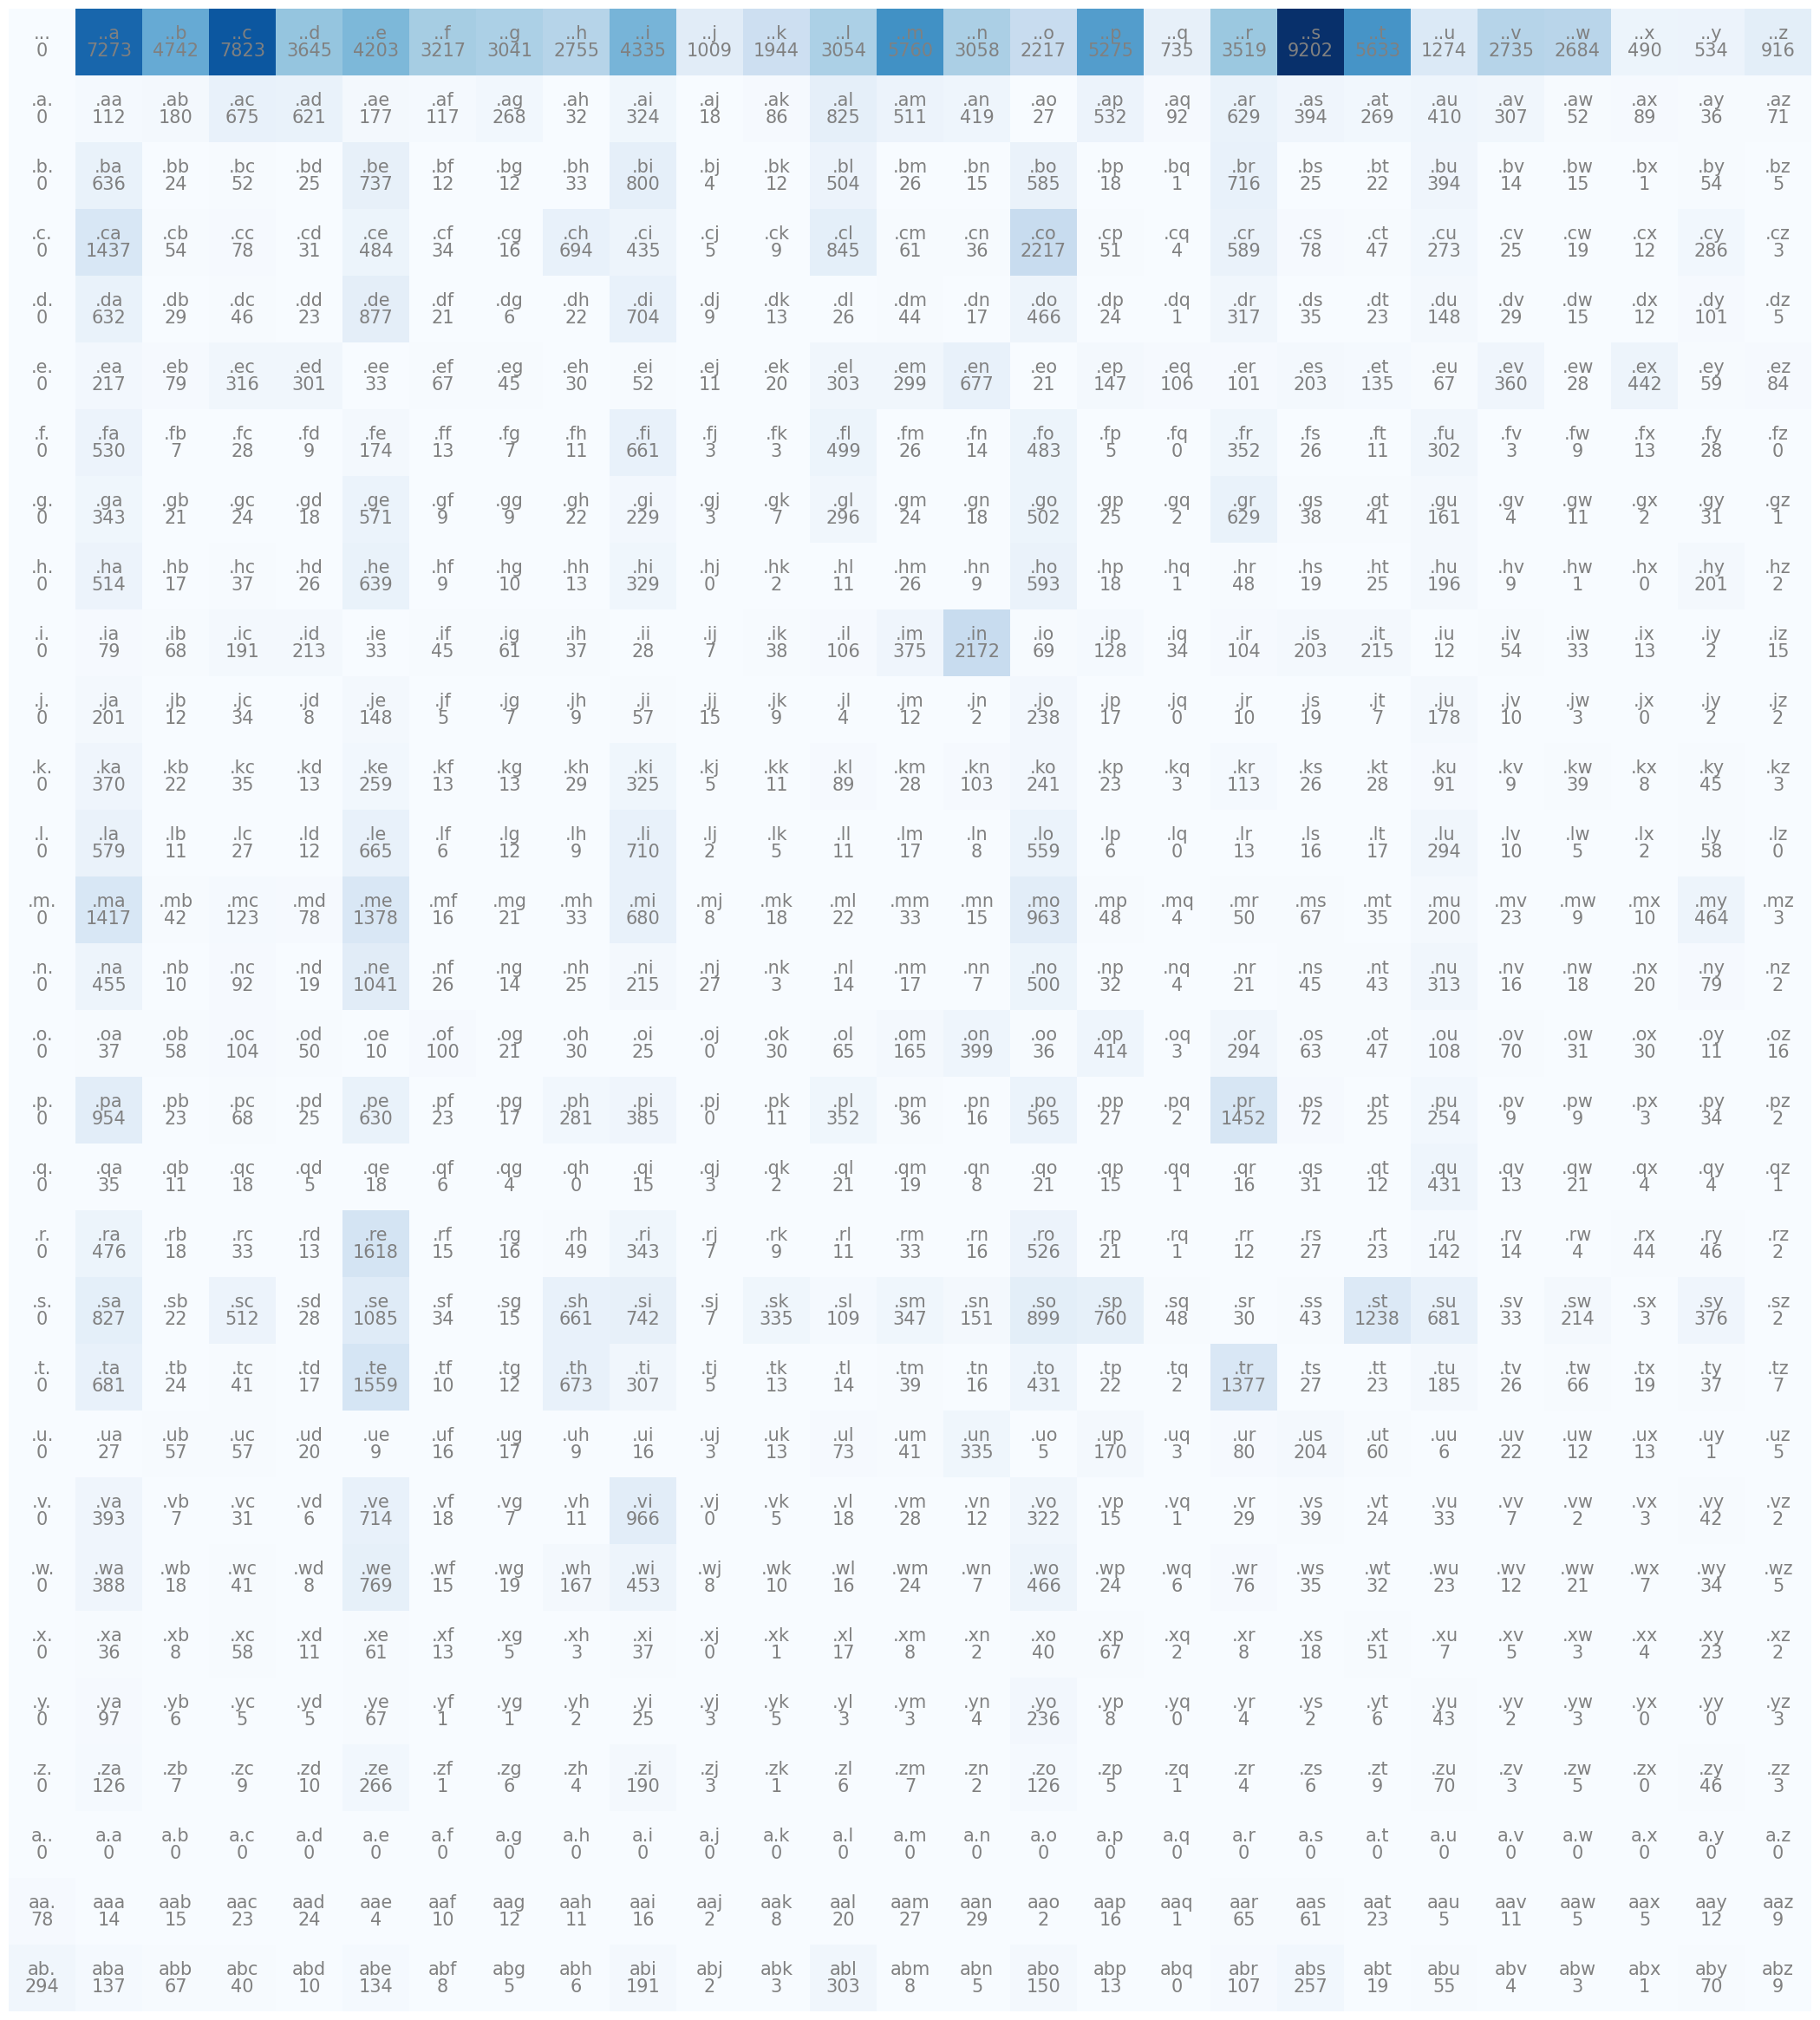

In [153]:
# 655 is because of the figsize parameter limit which is 2**16
# comment out below line to visualize all the trigrams (takes some time) 
# trc = 655
trc = 30

plt.figure(figsize=(27, trc))
plt.imshow(E[:trc, :], cmap='Blues')

for yy, row in enumerate(E[:trc, :]):
    for x, val in enumerate(row):
        plt.text(x, yy, f"{val}", va='top', ha='center', color='gray', fontsize=15)
        plt.text(x, yy, f"{inttostr_bi[yy] + inttostr[x]}", va='bottom', ha='center', color='gray', fontsize=15)
plt.axis('off');

In [154]:
2**16

65536

In [155]:
E[0, :]

tensor([   0, 7273, 4742, 7823, 3645, 4203, 3217, 3041, 2755, 4335, 1009, 1944,
        3054, 5760, 3058, 2217, 5275,  735, 3519, 9202, 5633, 1274, 2735, 2684,
         490,  534,  916], dtype=torch.int32)

In [156]:
p = E[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0799, 0.0521, 0.0859, 0.0400, 0.0461, 0.0353, 0.0334, 0.0303,
        0.0476, 0.0111, 0.0213, 0.0335, 0.0632, 0.0336, 0.0243, 0.0579, 0.0081,
        0.0386, 0.1010, 0.0619, 0.0140, 0.0300, 0.0295, 0.0054, 0.0059, 0.0101])

In [157]:
g = torch.Generator().manual_seed(10110609)
samples = torch.multinomial(p, 20, replacement=True, generator=g)

chs = []
for s in samples:
  ch = inttostr[s.item()]
  chs.append(ch)
sorted(chs)

['a',
 'b',
 'b',
 'c',
 'c',
 'c',
 'd',
 'g',
 'h',
 'm',
 'm',
 'n',
 'o',
 'p',
 'p',
 's',
 't',
 't',
 't',
 'v']

In [158]:
P = (E+1).float() # +1 is for model smoothing
P /= P.sum(axis=1, keepdims=True)

In [159]:
P.shape

torch.Size([729, 27])

In [160]:
# normalized each row to be probability. Each row sums to one.
(P[0, :]).sum()

tensor(1.)

In [161]:
P.dtype

torch.float32

In [162]:
# sampling from the model
g = torch.Generator().manual_seed(10110609)
samples = []

for i in range(20):
    letters = '..'

    word = ''

    while True:
        idx = strtoint_bi[letters]
        # p = E[idx].float()
        # p = p / p.sum()
        p = P[idx]
        next_letter_ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
        letter = inttostr[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        letters = letters[1:] + letter

    samples.append(word)
    print(word)

tics
nutelamic
prel
aycoa
med
hiastum
hbionse
perverakic
frouthrp
babs
drascloololawor
tovil
reelesto
temacenbytookidentar
mino
el
dai
scor
epinnocia
na


In [163]:
# samples that exist in the training data
[w for w in samples if w in companies]

['dai']

In [164]:
# compute the loss on the entire dataset or a single string

n = 0
log_likelihood = 0

# for word in ["openai"]:
for word in tqdm.tqdm(companies):
  word = ['.', '.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
    ix1 = strtoint_bi[ch1+ch2]
    ix2 = strtoint[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f"{log_likelihood=}")
neg_logl = -log_likelihood
print(f"{neg_logl=}")
loss = neg_logl/n
print(f"{loss=}")

100%|█████████████████████████████████████████████████| 91073/91073 [00:05<00:00, 15251.79it/s]

log_likelihood=tensor(-2070531.7500)
neg_logl=tensor(2070531.7500)
loss=tensor(2.4807)


In [ ]:
# increase the probability of the trigrams
# increase the loglikelihood
# decrease the negative loglikelihood
# decrease the average negative loglikelihood = decrease the loss

# Train, Test and Dev set

In [188]:
# splitting data into train, dev and test sets
random.seed(10110609)
random.shuffle(companies)
print("5 Example after shuffling: ", companies[:5])

n1 = int(len(companies) * 0.8)
n2 = int(len(companies) * 0.9)

X_train = companies[:n1]
X_dev = companies[n1:n2]
X_test = companies[n2:]

len(X_train), len(_), len(X_test)

5 Example after shuffling:  ['managedoffice', 'idmatrixindia', 'sightmd', 'popshelf', 'jaroop']


(72858, 9107, 9108)

In [189]:
# In this model, dev set would not be necessarily needed, 
  # just did to train and test on the same sets to compare

## Train / Evaluate the model

In [190]:
E = torch.zeros((len(alphabet) * len(alphabet), len(alphabet)), dtype=torch.int32)

In [191]:
# word = "tesla"
for word in tqdm.tqdm(X_train):  
  word = ['.', '.'] + list(word) + ['.']
  for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
    int1, int2, int3 = strtoint[ch1], strtoint[ch2], strtoint[ch3]
    int12 = strtoint_bi[ch1+ch2]
    E[int12, int3] += 1
#     print(ch1, ch2, ch3)
#     print(int1, int2, int3)

100%|██████████████████████████████████████████████████| 72858/72858 [00:07<00:00, 9592.72it/s]


In [194]:
E.shape

torch.Size([729, 27])

In [195]:
# probability
P = (E+1).float() # +1 is for model smoothing
P /= P.sum(axis=1, keepdims=True)

In [199]:
def evaluate(dataset):
  n = 0
  log_likelihood = 0

  for word in dataset:
    word = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
      ix1 = strtoint_bi[ch1+ch2]
      ix2 = strtoint[ch3]
      prob = P[ix1, ix2]
      logprob = torch.log(prob)
      log_likelihood += logprob
      n += 1


  print(f"{log_likelihood=}")
  neg_logl = -log_likelihood
  print(f"{neg_logl=}")
  loss = neg_logl/n
  print(f"{loss=}")

  return loss.item()

In [200]:
# compute the loss on the train and test set
print("Evaluation on the train set: ")
loss_train = evaluate(X_train)

print("\nEvaluation on the dev set: ")
loss_dev = evaluate(X_dev)

print("\nEvaluation on the test set: ")
loss_test = evaluate(X_test)

Evaluation on the train set: 
log_likelihood=tensor(-1656800.5000)
neg_logl=tensor(1656800.5000)
loss=tensor(2.4796)

Evaluation on the dev set: 
log_likelihood=tensor(-207735.1562)
neg_logl=tensor(207735.1562)
loss=tensor(2.4968)

Evaluation on the test set: 
log_likelihood=tensor(-208261.5000)
neg_logl=tensor(208261.5000)
loss=tensor(2.5007)


In [201]:
# Sample from the model
g = torch.Generator().manual_seed(10110609)
samples = []

for i in range(20):
    letters = '..'
    word = ''

    while True:
        idx = strtoint_bi[letters]
        # p = E[idx].float()
        # p = p / p.sum()
        p = P[idx]
        next_letter_ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
        letter = inttostr[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        letters = letters[1:] + letter

    samples.append(word)
    print(word)

tics
nutelamic
prel
aycoa
med
hiastum
hbjlste
perverakja
fsqurest
babs
drasbowfire
vme
tovil
reelesto
tenc
dkazvtecoaliomp
mino
el
dah
scor
